In [65]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import scipy as sp
import numpy as np
import pingouin as pg
%matplotlib inline

# ЗАДАНИЕ 1
Retention – один из самых важных показателей в компании. 
Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

In [66]:
# датафрейм со временем регистрации
reg_time = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ";")
reg_time

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [67]:
# датафрейм со временем захода пользователей в игру
play_time = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')
play_time

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


# 1.1 Предварительно проверим данные

In [68]:
# типы данных в датафреймах
play_time.dtypes

auth_ts    int64
uid        int64
dtype: object

In [69]:
reg_time.dtypes

reg_ts    int64
uid       int64
dtype: object

In [70]:
# типы данных целочисленные, впоследствии стоит проеобразовать время для удобной работы

In [71]:
# проверим на факт пропущенных значений
play_time.isna().sum()
# без пропущенных значений

auth_ts    0
uid        0
dtype: int64

In [72]:
reg_time.isna().sum()
# без пропущенных значений

reg_ts    0
uid       0
dtype: int64

In [73]:
# проверим на факт повторения айди в регистрациях
# дубликатов нет, всё ок
reg_time.value_counts()

reg_ts      uid    
1600874244  1110622    1
1543151183  370257     1
1543150868  370255     1
1543150711  370254     1
1543150553  370253     1
                      ..
1579569516  740371     1
1579569437  740370     1
1579569358  740369     1
1579569279  740367     1
911382223   1          1
Length: 1000000, dtype: int64

# 1.2 Напишем функцию для определения Retention

In [74]:
# на вход подаются необходимые датафреймы с датой регистрации и датой входа в игру,
# а также дата и рассматриваемый период
# опционально построение графика для выбранного нулевого дня
def retention(reg_df, play_df, year, month, days = 30, graph = 0, zero_day = None):
    
    '''на вход принимает 
        1. reg_df - дф с датой регистрации
        2. play_df - дф с датой входа в игру
        3. year - рассматриваемый год
        4. month - рассматриваемый месяц
        5. days - количество прошедших дней. По умолчанию 30 дней
        6. graph - изначально 0, опционально строит график
        7. zero_day для какой даты строим график retention/days, формат "YYYY-MM-DD"; показывает динамику RR
    '''
    zero_day = zero_day
    graph = graph
# объединим данные
    full_df = play_df.merge(reg_df, on = 'uid', how = 'left')
    # full_df - датафрейм с датой регистрации пользователей и временем захода в игру
    
# преобразуем unix-время в удобную дату
    full_df['reg_ts'] = pd.to_datetime(pd.to_datetime(full_df['reg_ts'], unit = 's').dt.date)
    full_df['auth_ts'] = pd.to_datetime(pd.to_datetime(full_df['auth_ts'], unit = 's').dt.date)
    
# посчитаем количество дней между датой регистрации и датой последнего захода в игру
    full_df['use_time'] = full_df['auth_ts'] - full_df['reg_ts']
    full_df['use_time'] = full_df['use_time'].dt.days

# выделим требуемый период
    full_df = full_df.query('reg_ts.dt.year == @year and reg_ts.dt.month == @month')

# нам требуется знать динамику клиентов за некоторый период
# сгруппируем таблицу по датам регистрации и временем использования приложением, посчитав количество пользователей
# в строке с use_time = 0 имеем новых пользователей на начало периода
    full_df = full_df.groupby(['reg_ts', 'use_time'], as_index = False).agg({'uid':'count'})
    
# преобразуем таблицу
# индексы - дата регистрации, столбцы - дни использования, значения - количество пользователей с такой датой регистрации и
# таким количеством использования приложения (игры)
    full_df = full_df.pivot(index = 'reg_ts', columns = 'use_time', values = 'uid')
# и заполним na нулём
    full_df = full_df.fillna(0)
    
# в столбце с use_time = 0 имеем новых пользователей на начало периода
# для удобства чтения переименуем его в 'new_users', а также добавим отдельно, чтобы
# была возможность обращаться к нему при итерации
    full_df.insert(0, 'new_users', full_df[0])

# расчёт метрики для каждого столбца
    for i in full_df.columns[1:days+2]:
        full_df[i] = 100 * ((full_df[i] / full_df['new_users']).round(2))
    full_df = full_df.iloc[:, 1:days+2]
    
####################
#   # опционально можно построить график для нужного нулевого дня (формат "YYYY-MM-DD")
    if graph != 0:
        
        # сбросим индексы и транспонируем матрицу, чтобы можно было легче использовать для графика y = f(x)
        df = full_df.reset_index()
        df = df[df['reg_ts'] == zero_day].T.reset_index()

        # уберём лишнюю строку и переименуем столбец, а также изменим тип данных на числовой
        df = df.drop(index = 0).rename(columns = {0:'retention'})
        df = df.astype(float)

        # построим линейный график
        sns.lineplot(y = df.iloc[:,1], x = 'use_time', data = df)
        plt.pyplot.xlabel("days")  # Название оси X
        plt.pyplot.ylabel("Retention")  # Название оси Y
    else:
        pass
#
####################

# вернём датафрейм с retention
    return full_df

    

In [75]:
#print(retention.__doc__)

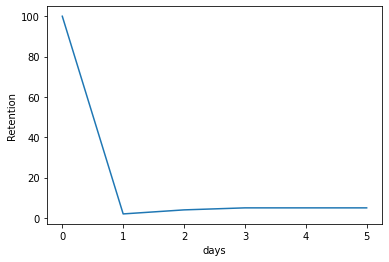

In [76]:
full_df = retention(reg_time, play_time, 2020, 1, 5, 1, '2020-01-11')

In [77]:
full_df

use_time,0,1,2,3,4,5
reg_ts,,,,,,
2020-01-01,100.0,3.0,5.0,3.0,6.0,6.0
2020-01-02,100.0,2.0,5.0,5.0,5.0,6.0
2020-01-03,100.0,2.0,3.0,4.0,5.0,7.0
2020-01-04,100.0,1.0,4.0,5.0,5.0,6.0
2020-01-05,100.0,2.0,4.0,5.0,4.0,5.0
2020-01-06,100.0,3.0,4.0,5.0,4.0,5.0
2020-01-07,100.0,2.0,5.0,4.0,6.0,5.0
2020-01-08,100.0,2.0,4.0,4.0,5.0,5.0
2020-01-09,100.0,2.0,4.0,5.0,4.0,6.0


# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [78]:
# прочитаем данные в переменную df
df = pd.read_csv('Проект_1_Задание_2.csv', sep = ";")
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


# 2.1. Предварительно проверим данные

In [79]:
# типы данных
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [80]:
# проверим на факт пропущенных значений
df.isna().sum()
# без пропущенных значений

user_id      0
revenue      0
testgroup    0
dtype: int64

In [81]:
# повторение id
# без повторений
df.user_id.value_counts()

2047      1
312370    1
324660    1
326709    1
320566    1
         ..
164613    1
170758    1
168711    1
191240    1
2049      1
Name: user_id, Length: 404770, dtype: int64

# 2.2 Обзорно посмотрим на данные

In [82]:
# разобьём датафрейм на две таблицы с контрольными и тестовыми группами
control = df.query('testgroup == "a"')
test = df.query('testgroup == "b"')

In [83]:
# посмотрим на свойства выборок
control.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [84]:
test.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


In [85]:
# std для revenue у контрольной группы сильно выше, чем у тестовой. Попробуем визуализировать данные

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


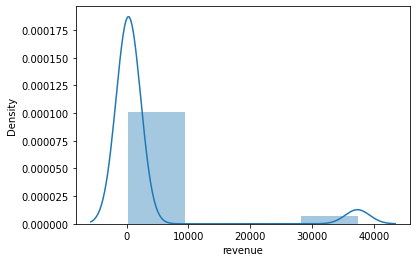

In [86]:
sns.distplot(control[control['revenue'] != 0]['revenue'], bins = 4)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


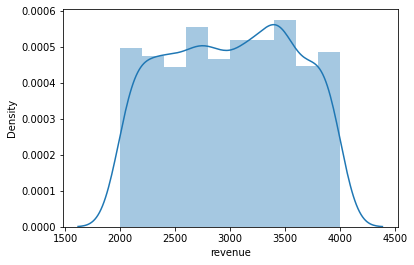

In [87]:
sns.distplot(test[test['revenue'] != 0]['revenue'], bins = 10)

#### Вид распределения выручки по пользователям кардинально отличается в тестовой и контрольной группе.
#### у тестовой группы оно относительно равномерное, для контрольной группы уже только визуально можно предположить наличие выбросов данных 

# 2.3 Разберёмся с особенностями контрольной группы

In [88]:
control

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [89]:
# айди с выручкой больше 20 т.
major_c = control.query('revenue > 20000')
major_c

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


In [90]:
major_c['revenue'].describe()
# 123 пользователя со средней выручкой в 37319

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

In [91]:
# айди с выручкой меньше 20 т.
minor_c = control.query('revenue < 20000 & revenue > 0')
minor_c

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
712,713,255,a
1346,1347,230,a
...,...,...,...
404304,404305,360,a
404315,404316,262,a
404543,404544,369,a
404602,404603,251,a


In [92]:
# 201980 платящих пользователя со средней выручкой в 302.45
minor_c['revenue'].describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

In [93]:
# посчитаем долю каждой группы в выручке контрольной группы
minor_rev = minor_c['revenue'].sum() / control['revenue'].sum()
minor_rev

0.10629223340496231

In [94]:
major_rev = 1 - minor_rev
major_rev

0.8937077665950377

##### Большую долю составляют пользователи с высоким показателем выручки.

##### 89.37% против 10.63% у группы с меньшими платежами, несмотря на их количественное превосходство (123 против 1805);

##### у группы с высокой выручкой разброс от 37293 до 37433
##### у группы с низкой выручкой - от 200 до 400

### Делаем вывод о том, что в контрольной группе оказалось два "сегмента" пользователей

# 2.4 Выбор метрик
### Предоставлены только данные о платежах: размере платежа, количество платящих и неплатящих пользователей; также известно различие в ARPU

## Можем посчитать:
#### ARPPU (так как известно, кто платящий пользователь, а кто - нет)
#### Conversion Rate (CR) - будем считать целевым действием любой платёж (revenue, отличное от нуля)
не представляется возможным посчитать метрики, связанные с расходами и временем, за неимением последних.

# 2.5 Расчёт метрик

## 2.5.1 Проверим достоверность различий в ARPU
ARPU - Cредний доход с привлечённого пользователя.

In [95]:
# arpu в контрольной группе
arpu_control = control['revenue'].sum()/control['revenue'].count()
arpu_control

25.413719736965806

In [96]:
# в тестовой группе
arpu_test = test['revenue'].sum()/test['revenue'].count()
arpu_test

26.75128659327863

In [97]:
# да, различие оказалось в 5%.
arpu_test/arpu_control

1.052631683600699

# Определим статистическую значимость различий
### нулевая гипотеза - различия между ARPU контрольной и тестовой группы отсутствуют
### альтернативная гипотеза - есть статзначимые различия между выборками

# Работаем со средними значениями по выборкам. Может подойти t-test.

#### Используем т-тест
для т-теста:
1. Дисперсии внутри наших групп должны быть примерно одинаковы
    проверим с помощью критерия Левена 
2. требование к нормальности данных обеих групп

In [98]:
# проверим гомогенность данных по выручке
# h0 - дисперсии однородны
sp.stats.levene(control['revenue'], test['revenue'])

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

In [99]:
# pvalue=0.53, p >> 0, не имеем оснований для того, чтобы отбросить гипотезу об однородности дисперсии

In [100]:
# проверим распределения на нормальность
# без логарифмирования выборки не проходят нулевую гипотезу о нормальности,
# но имеем достаточно большие выборки, поэтому попробуем позволить себе пренебречь этим
sp.stats.shapiro(np.log(control['revenue']))[1]

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


1.0

In [101]:
sp.stats.shapiro(np.log(test['revenue']))[1]

1.0

In [102]:
# проведём ttest
sp.stats.ttest_ind(test['revenue'], control['revenue'])

Ttest_indResult(statistic=0.6242026493616787, pvalue=0.532494858971837)

### pvalue > 0.05
### Не имеем оснований для того, чтобы отвергнуть H0, говорящую о том, что нет статзначимых различий между ARPU тестовой и контрольной группы

# ____ ______ _______
# 2.5.2 Посчитаем ARPPU и проведём статистический тест
ARPPU - средний доход на платящего пользователя 

In [103]:
# выручка платящих пользователей в контрольной и тестовой группе соответственно
pay_c = control.query('revenue > 0')['revenue']
pay_t = test.query('revenue > 0')['revenue']

In [104]:
# арппу в контрольной группе
arppu_control = control['revenue'].sum() / pay_c.count()
arppu_control

2663.9984439834025

In [105]:
# в тестовой
arppu_test = test['revenue'].sum() / pay_t.count()
arppu_test

3003.6581717451522

In [106]:
# проверим arppu на однородность дисперсий выборок, по которым мы его считали
# дисперсии оказались неоднородны, но попробуем сделать поправку на размер выборки
sp.stats.levene(test.query('revenue > 0')['revenue'], control.query('revenue > 0')['revenue'])

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

# Определим статистическую значимость различий

# Работаем со средними значениями по выборкам. Может подойти t-test.

### нулевая гипотеза - различия между ARPPU контрольной и тестовой группы отсутствуют
### альтернативная гипотеза - есть статзначимые различия между выборками
#### Используем т-тест

In [107]:
# выручка платящих пользователей в контрольной и тестовой группе соответственно
pay_c = control.query('revenue > 0')['revenue']
pay_t = test.query('revenue > 0')['revenue']

In [108]:
# попробуем использовать ttest Уэлча, поскольку имеем неднородные дисперсии
# при equal_var = False рассчитывается по Уэлчу
sp.stats.ttest_ind(pay_c, pay_t, equal_var = False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

### Из-за неоднородности дисперсий и ненормального распределения групп есть сомнения в том, насколько адекватно t-test работает в этом случае. Попробуем использовать bootstrap. 

In [109]:
# воспользуемся бутстрэпом из библиотеки pingouin
# посчитаем доверительный интервал для среднего значения выручки у контрольной группы
pg.compute_bootci(pay_c, func = np.mean)

array([2279.22, 3066.64])

In [110]:
np.mean(pay_t)

3003.6581717451522

Среднее значение из одной выборки попадает в доверительный интервал другой.

2280 < 3003  < 3068

# pvalue > 0.05
### не имеем оснований отклонить нулевую гипотезу о том, что ARPPU в тестовой и контрольной группе не отличаются

# ____ ______ _______
# 2.5.3 Conversion Rate
Конверсия (conversion rate, CR) — отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу пользователей.

Будем считать целевым действием факт имеющегося платежа (revenue > 0)

In [111]:
# число платящих пользователей в контрольной и тестовой группе соответственно
cr_c = control.query('revenue > 0')['revenue'].count()
cr_t = test.query('revenue > 0')['revenue'].count()
(cr_c, cr_t)

(1928, 1805)

In [112]:
cr_control = cr_c / control['revenue'].count()
cr_control

0.009539690157988749

In [113]:
cr_test = cr_t / test['revenue'].count()
cr_test

0.008906235351586593

# Выбор метода для статистической проверки

### В отличие от ARPU и ARPPU, представляющих собой количественные метрики, в CR работаем с категориальными данными (разбиваем пользователей на категорию "платящий" и "неплатящий")

## В таком случае используется метод хи-квадрат

In [114]:
# для хи-квадрата требуется использовать таблицу сопряженности,
# в которой будут данные по факту платежа и его отсутствия по двум группам одновременно
# создадим в основном датафрейме столбец, в котором 1 - это наличие платежа, 0 - отсутствие у соответствующего юзера 
df['paid'] = df['revenue'].apply(lambda x: '1' if x > 0 else '0')
df

,user_id,revenue,testgroup,paid
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


In [115]:
# сгруппируем таблицу по платежу и факту платежа, подсчитав количество юзеров
cross_df = df.groupby(['testgroup', 'paid'], as_index = False).agg({'user_id':'count'})
cross_df = cross_df.pivot(index = 'paid', columns = 'testgroup', values = 'user_id')

In [116]:
# получившаяся таблица
# строки 0, 1 - отсутствие и присутствие платежа соответсвтенно
# a, b - контрольная и тестовая группа
cross_df

testgroup,a,b
paid,,
0,200175,200862
1,1928,1805


### Используем критерий хи-квадрат

Нулевая гипотеза - никакой статистической связи нет.

Альтернативная - связь между конверсиями двух групп есть.

In [117]:
sp.stats.chi2_contingency(cross_df)

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104, 200797.89924896],
        [  1863.89924896,   1869.10075104]]))

# p = 0.036 < 0.05
## отклоняем нулевую гипотезу. Есть статистически значимые различия между конверсиями контрольной и тестовой группы

In [118]:
# различие между конверсиями в процентах
# конверсия в контрольной группе выше.
((cr_control - cr_test) * 100).round(3)

0.063

# ____ ______ ____________ ____ ____ ____ _____ ____  ___ ____ ____ ______ ____________ ____ ____ ____ _____ ____  ___ ____ 

# ВЫВОД

Ещё раз пройдёмся по полученным результатам:

1. Статистически значимых различий между ARPU и ARPPU между группами не оказалось, то есть не имеем оснований полагать, что выручка на пользователя увеличилась после предложения других наборов акционных предложений
2. Разница в показателях конверсии оказалась статистически значимой. При этом важно заметить, что конверсия выше именно в контрольной группе.

Можно сделать следующий вывод: акционные предложения, использованные на тестовой группе, не влияют на среднюю выручку с пользователя. Кроме того, они снижают конверсию, то есть являются менее эффективными, чем старые предложения.

Что делаем: сворачиваем тестирование, прекращаем предлагать новые акционные наборы, стараемся разработать предложения, повышающие конверсию.
В условии задания не сказано о конкретной бизнес-модели с её особенностями и свойствами, поэтому достаточно проблематично дать конкретные предложения по улучшению показателей. Может быть, стоит дать более привлекательные акционные наборы пользователям.

# Задание 3.
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. 
В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. 
Для получения награды требуется пройти ряд уровней за определенное время. 
С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

## 3.1 Метрики прошедших событий
Итак, есть пользователи, события и уровни, количество времени, получение плюшек (предметов и т.д.)

#### Начнём с количества пользователей и временем. Метрики, которые могут подойти:

Дневная аудитория (DAU), Месячная аудитория (MAU), Доля новых пользователей, (avg. DAU/MAU) = stickness ratio;

DAU и MAU может помочь узнать, как много внимания привлекает событие;

avg. DAU/MAU может помочь узнать, степень того, насколько интересно это событие в течение месяца

Также может подойти Retention: позволит узнать, интересна ли игра в целом. Если RR низкий, это означает, что игроки приходят во время ажиотажа (см. "на хайпе" :) ), но игра не удерживает их.

Также определённо стоит рассмотреть ASL (average session length), сколько в среднем проводят времени в игре игроки до/после события.

#### Метрики, связанные с элементами события
Конверсия, CR

Можем посчитать долю игроков, которые зашли в игру и дошли до определённого уровня (например, до уровня N, на котором даётся первый игровой предмет за всё событие); посчитать долю игроков, дошедших до последнего уровня и т.п. 
Тем самым мы можем определить, насколько интересно/сложно событие.

#### Метрики, связанные с платежами
Если в игре есть механика внутриигровых платежей, то стоит рассмотреть ARPPU.
Его динамика позволит узнать, насколько событие подогревает интерес к игре и к покупке предметов (например, это может сделать полученный предмет во время события)

#### Прочие метрики
Если в игре есть реферальная система (есть возможность узнать о факте приглашения игрока другим юзером), стоит рассмотреть 
Фактор виральности. Если он высок, значит, событие удачно, игрокам хочется провести его с друзьями, видеть больше людей в игре, получать бонусы и т.д.

## 3.1 Усложнение уровней
Нельзя сказать точно, как изменятся все метрики. Но можно предположить динамику некоторых метрик, и впоследствии стоит посмотреть их влияние на другие метрики.

Например, при усложнении уровней стоит обратить на следующие метрики:
1. ASL, CR - скорее всего, они уменьшатся. Отбрасывание на несколько уровней назад вероятнее всего уменьшат среднюю продолжительность сессии и долю игроков, дошедших до N уровня (кто-то опускает руки и интерес, когда встречает "непроходимый" уровень)
2. Фактор виральности может увеличиться. Если есть возможность проходить уровни кооперативно, то игроки могут позвать на помощь друзей.
3. Если покупка предметов поможет проходить уровни, то есть шанс, что увеличится ARPU и ARPPU.

В целом, нельзя отбрасывать никакие из перечисленных в п.1 метрики. Нужно аккуратно следить за степенью повышения сложности уровней, чтобы не оттолкнуть игроков, а подогреть их интерес.